# Chapter 18: Forecasting from Time Series Data

How to use time series data for predictions with the help of trends, seasonality, serial correlation, and predicted values of other variables

This chapter discusses forecasting: prediction from time series data for one or more time periods in the future.


# Key Terms

- forecast horizon: the length of the time period we want to forecast for

### Long-Horizon Forecasting: Seasonality and Predictable Events

- In Chapter 12, our goal was to use time series data to uncover patterns of association between y and x. For such analyses, these features created challenges, potentially leading to spurious association or biased standard error estimates. Thus, we discussed models that would address these features to eliminate, or mitigate, their influences. But here our goal is different: we want to predict future values of y. For forecasts, some of those features turn out to be great help.

- Seasonal differences and differences related to predictable events can be a great help in forecasting.

- We can model trend as a change, e.g., Δy = αˆ. Then we forecast y values by adding predicted changes to the last observation in the original time series (to yT).

-  Alternatively, we can model trend as trend line, e.g., ˆyt = αˆ + ˆδt.
-  An estimated trend leads to larger prediction error further ahead.

Trends:

- When our goal is prediction, we may model a trend in two ways: estimating the average change or fitting a trend line

In [7]:
import pandas as pd
import numpy as np

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Statistical Tests
from arch.unitroot import PhillipsPerron
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Other
import pandas_market_calendars as mcal

# Case Study - Forecasting Daily Ticket Volumes for a Swimming Pool

Our first case study is forecasting swimming pool ticket sales in an outdoor swimming pool in Albuquerque (ABQ, in short), the largest city in New Mexico, USA. In particular, we want to predict the number of tickets sold (ticket volume) for each day for one year in the future. We use the swim-transactions dataset in this case study.

In [47]:
swim_df = pd.read_csv("/workspaces/data-analysis-business-economics-policy/resources/data/ch18/swim_work.csv")

In [48]:
# Data Preprocessing

# Time features
swim_df['date'] = pd.to_datetime(swim_df['date'])
swim_df["year"] = swim_df["date"].dt.year
swim_df["quarter"] = swim_df["date"].dt.quarter
swim_df["month"] = swim_df["date"].dt.month
swim_df["day"] = swim_df["date"].dt.day
swim_df["dow"] = swim_df["date"].dt.dayofweek + 1
swim_df["weekend"] = swim_df["dow"].isin([6, 7])

# School Features
swim_df["school_off"] = (
    ((swim_df["day"] > 15) & (swim_df["month"] == 5) & (swim_df["day"] <= 30))
    | ((swim_df["month"] == 6) | (swim_df["month"] == 7))
    | ((swim_df["day"] < 15) & (swim_df["month"] == 8))
    | ((swim_df["day"] > 20) & (swim_df["month"] == 12))
)

# Holidays
nyse = mcal.get_calendar("NYSE")
holidays = nyse.holidays().holidays
swim_df["isHoliday"] = swim_df["date"].isin(holidays)


# trend
swim_df["trend"] = swim_df.index + 1

In [49]:
fig = px.line(data_frame=swim_df, x='date', y='QUANTITY', width=1000, height=600)
fig.update_layout(xaxis=dict(tickformat="%Y-%m"  ))
fig.show()

In [50]:
px.box(swim_df, x='month', y='QUANTITY')

In [51]:
px.box(swim_df, x='dow', y='QUANTITY')

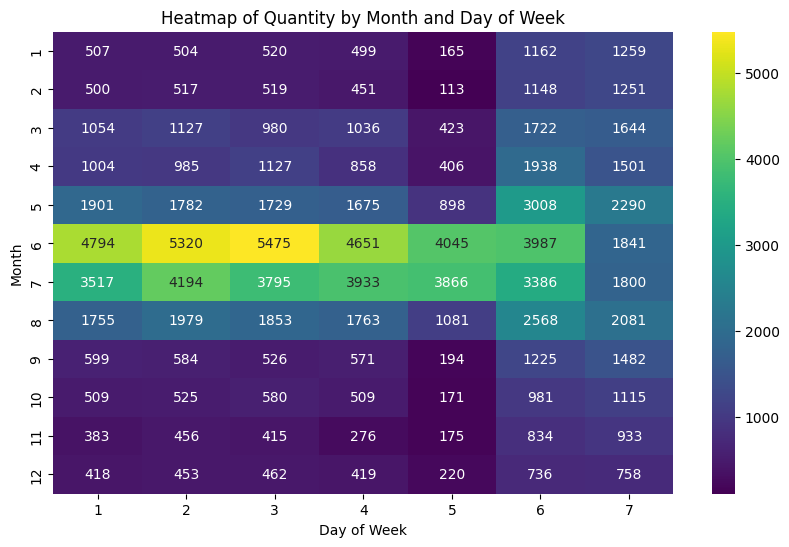

In [52]:
# Pivot the data to create a 2D matrix
heatmap_data = swim_df.pivot_table(values='QUANTITY', index='month', columns='dow', aggfunc='sum')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="g", cmap='viridis')
plt.title('Heatmap of Quantity by Month and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.show()

In [53]:
# Model Building

# Create train/holdout datasets
train = swim_df[(swim_df['date']<'2016-01-01')]
test = swim_df[(swim_df['date']>='2016-01-01')]


In [58]:
def fit_cv_model(features: list):
    X = train[features]
    y = train['QUANTITY']

    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize lists to store evaluation metrics
    rmse_scores = []

    # Iterate over train-test splits and train models
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit ARIMA model
        model = LinearRegression().fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Calculate Mean Squared Error
        mse = mean_squared_error(y_test, predictions)
        rmse_scores.append(np.sqrt(mse))

        print(f'Root Mean Squared Error for current split: {np.sqrt(mse)}')

    # Calculate average Mean Squared Error across all splits
    average_rmse = np.mean(rmse_scores)
    print(f'Average Root Mean Squared Error across all splits: {average_rmse}')
    return model

In [59]:
model1 = fit_cv_model(features=['trend', 'month'])

Root Mean Squared Error for current split: 98.65973543353819
Root Mean Squared Error for current split: 49.63855779099172
Root Mean Squared Error for current split: 46.8790179438812
Root Mean Squared Error for current split: 48.13945067867148
Root Mean Squared Error for current split: 44.926667806454404
Average Root Mean Squared Error across all splits: 57.6486859307074


In [60]:
model2 = fit_cv_model(features=["trend", "month", "dow"])

Root Mean Squared Error for current split: 95.4248300333795
Root Mean Squared Error for current split: 49.754200684415366
Root Mean Squared Error for current split: 47.002637710852895
Root Mean Squared Error for current split: 48.196363162720054
Root Mean Squared Error for current split: 44.96545463561412
Average Root Mean Squared Error across all splits: 57.06869724539638


In [62]:
model3 = fit_cv_model(features=["trend", "month", "dow", "isHoliday"])

Root Mean Squared Error for current split: 95.62183656324635
Root Mean Squared Error for current split: 49.69838617326508
Root Mean Squared Error for current split: 47.00222273478127
Root Mean Squared Error for current split: 48.095751388469054
Root Mean Squared Error for current split: 44.87134900785794
Average Root Mean Squared Error across all splits: 57.05790917352393


In [64]:
train['school_off_dow'] = train['school_off'] * train['dow']
model4 = fit_cv_model(features=["trend", "month", "dow", "isHoliday", "school_off_dow"])

Root Mean Squared Error for current split: 82.2258220952315
Root Mean Squared Error for current split: 42.97711310050768
Root Mean Squared Error for current split: 42.95777177240806
Root Mean Squared Error for current split: 43.2327233383016
Root Mean Squared Error for current split: 39.0905661976091
Average Root Mean Squared Error across all splits: 50.09679930081159


/tmp/ipykernel_2171/2733127731.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

